# Fruit multiclassification

- Fabio Villa ()
- Luca Perfetti ()
- Francesco Cavallini (920835)

Volgiamo realizzare un progetto che, letto un [dataset contenente diversi istanze di frutti ripotati di 360](https://www.kaggle.com/datasets/moltean/fruits/code), implementi un modello di rete neurale (basato su CNN) che permetta la multi calssificazione dei vari gruppi di frutta.fornita. Ossia, più nello specifico, vogliamo creare diverse istanze di reti neurali (sotto forma modalità trial and error) per arrivare a vedere quali sono le performmance più realistiche possibiili che possiamo ottenere addestrando una rete neurale per predirre due label; dove le label in questione rappresentano:
- label 1: categoria generale di frutto (eg: "apple")
- label 2: sotto-categoria di frutto (eg: "apple golden", "apple red", ...)


## Setup

Semplice sezione di setup delle librerie e del dirve

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import defaultdict
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.image as mpimg
from anytree import Node, RenderTree
from anytree.exporter import DotExporter
from PIL import ImageEnhance
import random

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet101, VGG19
import logging
from numpy.random import RandomState
from sklearn import cluster, decomposition
from sklearn.datasets import fetch_lfw_people
import seaborn as sns
import tensorflow as tf
from tensorflow.data import Dataset

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
import numpy as np
from keras.layers import Input, Lambda
from tensorflow.keras.models import load_model
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications import MobileNet
import cv2
from tensorflow.keras.applications.vgg19 import preprocess_input


rng = RandomState(0)

## Lettura dataset

Dalla documentazione si evice che il dataset a nostra disposizione contiene 141 istanze di diversi frutti che vengono fatti ruotare di 360 gradi. Ma si nota che i dati a nostra disposizione non sono perfettamente integri, per questo motivo i dati vengono modificati manualmente (eliminando circa 20 classi) per garantire l'integrità dei dati. Questo step verrà meglio spiegto nella relazione. 

Di seguito procediamo con la lettura del dataset che abbiamo mantenuto:

In [2]:
dataset_path = 'Dataset\\'

### Setup dei dictionaries

Inizializzazione di dictionary che associa labels_2 (eg: "apple golden") ad un numero intero

In [3]:
# Initialize dictionaries and lists
labels_2_int = {}
labels_2_array = []
labels_1_array = []

# Counter for consecutive numbering
counter = 0

# Iterate over the subdirectories using case-insensitive sorting
for folder_name in sorted(os.listdir(dataset_path + "val\\"), key=str.lower):
    # Map folder name to an integer
    folder_name = folder_name[:-2]
    if len(folder_name.split(' ')) == 1:
        folder_name = folder_name.split(' ')[0] + " Undefined"
    
    if folder_name not in labels_2_int:
        labels_2_int[folder_name] = counter
        labels_2_array.append(folder_name)
        counter += 1
        print(folder_name)
        
    if folder_name.split(' ')[0] not in labels_1_array:
        labels_1_array.append(folder_name.split(' ')[0])

Apple Undefined
Apple Braeburn
Apple Crimson Snow
Apple Golden
Apple Granny Smith
Apple hit
Apple Pink Lady
Apple Red
Apple Red Delicious
Apple Red Yellow
Apricot Undefined
Avocado Undefined
Avocado ripe
Banana Undefined
Banana Lady Finger
Banana Red
Beetroot Undefined
Blueberry Undefined
Cabbage white
Cactus fruit
Cantaloupe Undefined
Carambula Undefined
Carrot Undefined
Cauliflower Undefined
Cherry Undefined
Cherry Rainier
Cherry Wax Black
Cherry Wax Red
Cherry Wax Yellow
Chestnut Undefined
Clementine Undefined
Cocos Undefined
Corn Undefined
Corn Husk
Cucumber Undefined
Cucumber Ripe
Dates Undefined
Eggplant Undefined
Eggplant long
Fig Undefined
Ginger Root
Granadilla Undefined
Grape Blue
Grape Pink
Grape White
Grapefruit Pink
Grapefruit White
Guava Undefined
Hazelnut Undefined
Huckleberry Undefined
Kaki Undefined
Kiwi Undefined
Kohlrabi Undefined
Kumquats Undefined
Lemon Undefined
Lemon Meyer
Limes Undefined
Lychee Undefined
Mandarine Undefined
Mango Undefined
Mango Red
Mangostan Un

In [4]:
print(len(labels_2_array))

121


In [5]:
labels_2_int

{'Apple Undefined': 0,
 'Apple Braeburn': 1,
 'Apple Crimson Snow': 2,
 'Apple Golden': 3,
 'Apple Granny Smith': 4,
 'Apple hit': 5,
 'Apple Pink Lady': 6,
 'Apple Red': 7,
 'Apple Red Delicious': 8,
 'Apple Red Yellow': 9,
 'Apricot Undefined': 10,
 'Avocado Undefined': 11,
 'Avocado ripe': 12,
 'Banana Undefined': 13,
 'Banana Lady Finger': 14,
 'Banana Red': 15,
 'Beetroot Undefined': 16,
 'Blueberry Undefined': 17,
 'Cabbage white': 18,
 'Cactus fruit': 19,
 'Cantaloupe Undefined': 20,
 'Carambula Undefined': 21,
 'Carrot Undefined': 22,
 'Cauliflower Undefined': 23,
 'Cherry Undefined': 24,
 'Cherry Rainier': 25,
 'Cherry Wax Black': 26,
 'Cherry Wax Red': 27,
 'Cherry Wax Yellow': 28,
 'Chestnut Undefined': 29,
 'Clementine Undefined': 30,
 'Cocos Undefined': 31,
 'Corn Undefined': 32,
 'Corn Husk': 33,
 'Cucumber Undefined': 34,
 'Cucumber Ripe': 35,
 'Dates Undefined': 36,
 'Eggplant Undefined': 37,
 'Eggplant long': 38,
 'Fig Undefined': 39,
 'Ginger Root': 40,
 'Granadilla U

Inizializzazione di un dictionary che associa labels_1 (eg: "appple") ad un numero intero

In [6]:
labels_1_int = {}
for i, fruit_name in enumerate(labels_1_array):
    # Map folder name to an integer
    labels_1_int[fruit_name] = i
    print(fruit_name)

Apple
Apricot
Avocado
Banana
Beetroot
Blueberry
Cabbage
Cactus
Cantaloupe
Carambula
Carrot
Cauliflower
Cherry
Chestnut
Clementine
Cocos
Corn
Cucumber
Dates
Eggplant
Fig
Ginger
Granadilla
Grape
Grapefruit
Guava
Hazelnut
Huckleberry
Kaki
Kiwi
Kohlrabi
Kumquats
Lemon
Limes
Lychee
Mandarine
Mango
Mangostan
Maracuja
Melon
Mulberry
Nectarine
Nut
Onion
Orange
Papaya
Passion
Peach
Pear
Pepino
Pepper
Physalis
Pineapple
Pitahaya
Plum
Pomegranate
Pomelo
Potato
Quince
Rambutan
Raspberry
Redcurrant
Salak
Strawberry
Tamarillo
Tangelo
Tomato
Walnut
Watermelon
Zucchini


In [7]:
labels_1_int

{'Apple': 0,
 'Apricot': 1,
 'Avocado': 2,
 'Banana': 3,
 'Beetroot': 4,
 'Blueberry': 5,
 'Cabbage': 6,
 'Cactus': 7,
 'Cantaloupe': 8,
 'Carambula': 9,
 'Carrot': 10,
 'Cauliflower': 11,
 'Cherry': 12,
 'Chestnut': 13,
 'Clementine': 14,
 'Cocos': 15,
 'Corn': 16,
 'Cucumber': 17,
 'Dates': 18,
 'Eggplant': 19,
 'Fig': 20,
 'Ginger': 21,
 'Granadilla': 22,
 'Grape': 23,
 'Grapefruit': 24,
 'Guava': 25,
 'Hazelnut': 26,
 'Huckleberry': 27,
 'Kaki': 28,
 'Kiwi': 29,
 'Kohlrabi': 30,
 'Kumquats': 31,
 'Lemon': 32,
 'Limes': 33,
 'Lychee': 34,
 'Mandarine': 35,
 'Mango': 36,
 'Mangostan': 37,
 'Maracuja': 38,
 'Melon': 39,
 'Mulberry': 40,
 'Nectarine': 41,
 'Nut': 42,
 'Onion': 43,
 'Orange': 44,
 'Papaya': 45,
 'Passion': 46,
 'Peach': 47,
 'Pear': 48,
 'Pepino': 49,
 'Pepper': 50,
 'Physalis': 51,
 'Pineapple': 52,
 'Pitahaya': 53,
 'Plum': 54,
 'Pomegranate': 55,
 'Pomelo': 56,
 'Potato': 57,
 'Quince': 58,
 'Rambutan': 59,
 'Raspberry': 60,
 'Redcurrant': 61,
 'Salak': 62,
 'Strawbe

In [8]:
print(len(labels_1_int))

70


Questi due dictionaries sono poi utili alla lettura del dataset, siccome, con questi possiamo assegnare ad ogni classe un intero

### Creazione dei file numpy array

#### Funzioni di modifica immagini

Siccome si ha che ogni cartella è formata da sample dello stesso oggetto frutto ma ruotato di 360 gradi, si riconosce che trainare su un dataset del genere porterebbe ad apprendere solo determinate feature di quell'ogetto ma i vari modelli non imparerebbero a generalizzare. Per questo motivo si decide di creare una seri di funzioni che inseriscono delle distorsioni dell'imagnine campione originale all'interno del dataset. Alcune di queste sono:

In [9]:
img = load_img("TrainingFabio_Extracted_data\\test\Apple Braeburn\\2_100.jpg", target_size=(128, 128)) 

--------

In [10]:
def random_flip(img):
    # Convert the image to a numpy array
    img_array = img_to_array(img)
    
    # Randomly decide whether to flip along x-axis and/or y-axis
    flip_x = np.random.choice([True, False])
    flip_y = np.random.choice([True, False])
    
    if flip_x:
        img_array = np.flip(img_array, axis=1)
    if flip_y:
        img_array = np.flip(img_array, axis=0)
    
    # Convert the numpy array back to a PIL image
    flipped_img = Image.fromarray(img_array.astype('uint8'), 'RGB')
    
    return flipped_img

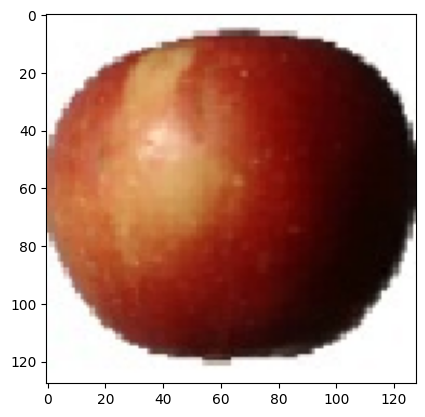

In [11]:
plt.imshow(random_flip(img))

--------

In [12]:
def translate_image(img, max_translation=60):
    # Converti l'immagine in un array numpy
    img_array = np.array(img)
    
    # Genera traslazioni casuali per x e y
    tx = np.random.randint(-max_translation, max_translation + 1)
    ty = np.random.randint(-max_translation, max_translation + 1)
    
    # Crea una nuova immagine bianca con le stesse dimensioni
    translated_img = Image.new('RGB', img.size, (255, 255, 255))
    
    # Calcola le coordinate di incollaggio
    x_offset = max(0, tx)
    y_offset = max(0, ty)
    
    # Incolla l'immagine originale nella nuova immagine traslata
    translated_img.paste(img, (x_offset, y_offset))
    
    # Ritaglia l'immagine per mantenere le dimensioni originali
    translated_img = translated_img.crop((0, 0, img.size[0], img.size[1]))
    
    return translated_img

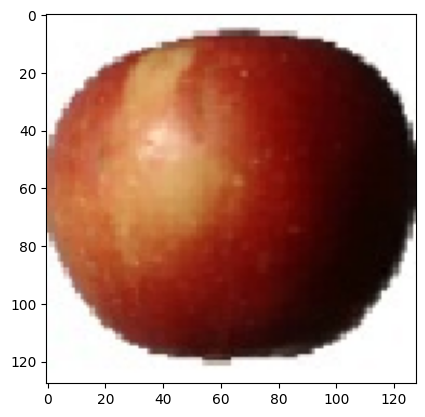

In [13]:
plt.imshow(translate_image(img))

------

In [14]:
def random_brightness(img, min_factor=0.9, max_factor=1.3):
    # Convert the image to a numpy array
    img_array = img_to_array(img)
    
    # Generate a random brightness factor
    brightness_factor = np.random.uniform(min_factor, max_factor)
    
    # Adjust the brightness, but do not modify pixels with value 255
    img_array = np.where(img_array < 24, np.clip(img_array * brightness_factor, 0, 255), img_array)
    
    # Convert the numpy array back to a PIL image
    bright_img = Image.fromarray(img_array.astype('uint8'), 'RGB')
    
    return bright_img

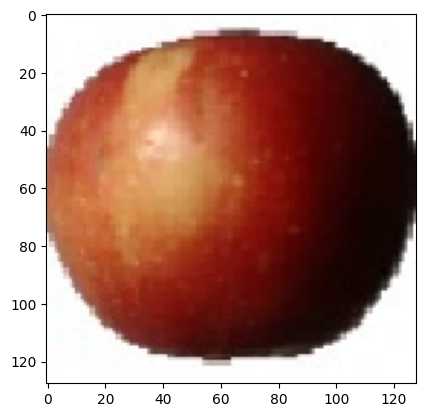

In [15]:
plt.imshow(random_brightness(img))

-----

In [16]:
def random_rgb_shift(img, max_shift=25):
    # Convert the image to a numpy array
    img_array = img_to_array(img)
    
    # Generate random shifts for each channel
    shift_r = np.random.randint(-max_shift, max_shift + 1)
    shift_g = np.random.randint(-max_shift, max_shift + 1)
    shift_b = np.random.randint(-max_shift, max_shift + 1)
    
    # Apply the shifts to each channel, but do not modify pixels with value 255
    img_array[..., 0] = np.where(img_array[..., 0] < 240, np.clip(img_array[..., 0] + shift_r, 0, 255), img_array[..., 0])
    img_array[..., 1] = np.where(img_array[..., 1] < 240, np.clip(img_array[..., 1] + shift_g, 0, 255), img_array[..., 1])
    img_array[..., 2] = np.where(img_array[..., 2] < 240, np.clip(img_array[..., 2] + shift_b, 0, 255), img_array[..., 2])
    
    # Convert the numpy array back to a PIL image
    shifted_img = Image.fromarray(img_array.astype('uint8'), 'RGB')
    
    return shifted_img

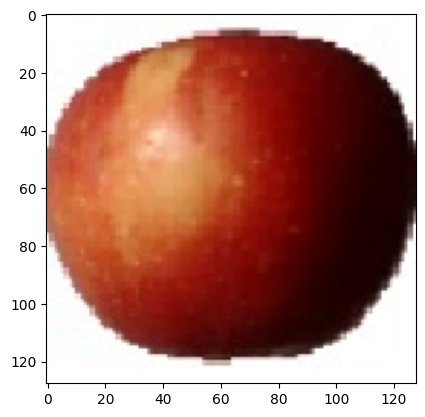

In [17]:
plt.imshow(random_rgb_shift(img))

-----

In [18]:
def random_stretch(img, max_stretch=0.07):
    # Convert the image to a numpy array
    img_array = np.array(img)
    
    # Get the original dimensions
    original_height, original_width = img_array.shape[:2]
    
    # Generate random stretch factors for x and y axes
    stretch_x = 1 + np.random.uniform(-max_stretch, max_stretch)
    stretch_y = 1 + np.random.uniform(-max_stretch, max_stretch)
    
    # Calculate new dimensions
    new_width = int(original_width * stretch_x)
    new_height = int(original_height * stretch_y)
    
    # Resize the image
    stretched_img = img.resize((new_width, new_height), Image.LANCZOS)
    
    # Create a new white image with the original dimensions
    output_img = Image.new('RGB', (original_width, original_height), (255, 255, 255))
    
    # Calculate the position to paste the stretched image
    x_offset = (original_width - new_width) // 2
    y_offset = (original_height - new_height) // 2
    
    # Paste the stretched image onto the new white image
    output_img.paste(stretched_img, (x_offset, y_offset))
    
    return output_img

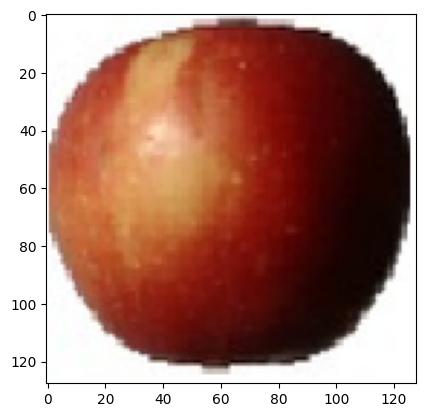

In [19]:
plt.imshow(random_stretch(img))

-----

In [20]:
def random_resize_and_repeat(img, min_scale=0.1, max_scale=0.5, num_repeats=10):
    # Convert the image to a numpy array
    img_array = np.array(img)
    
    # Create a white background image
    output_img = Image.new('RGB', img.size, (255, 255, 255))
    
    for _ in range(num_repeats):
        # Generate a random scale factor
        scale_factor = np.random.uniform(min_scale, max_scale)
        
        # Calculate new dimensions
        new_width = int(img.size[0] * scale_factor)
        new_height = int(img.size[1] * scale_factor)
        
        # Resize the image
        resized_img = img.resize((new_width, new_height), Image.LANCZOS)
        
        # Generate random position
        x_offset = np.random.randint(0, img.size[0] - new_width + 1)
        y_offset = np.random.randint(0, img.size[1] - new_height + 1)
        
        # Create a mask to handle transparency
        mask = resized_img.convert("L").point(lambda x: 0 if x > 230 else 255, mode='1')
        
        # Paste the resized image onto the white background using the mask
        output_img.paste(resized_img, (x_offset, y_offset), mask)
    
    return output_img

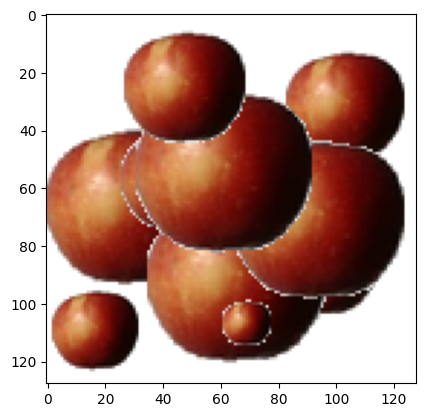

In [21]:
plt.imshow(random_resize_and_repeat(img))

#### Funzione lettura dataset

Si definisce la seguente funzione adibita a crare dei file .npz (numpy array) che serviranno successivamente a leggere l'intero dataset instantaneamente (invece che dover attendere lunghi tempi di attesa solo per caricare il dataset)

Di seguito viene chimata la funzione per creare i file di train/test/validation sets:

#### File train

Nota che in questo caso viene anche plottato un grafico che mostra un sample per ogni frutto disponibile nel nostro dataset. Questo plot è stato poi salvato in memoria di modo da porter comunque venire visualizzato anche quando non si esegue la funzione mostrata precedentemente:

#### File validazione

scrittura file validation set con la stessa funzione

#### File test

scrittura file test set con la stessa funzione

### Lettura file numpy array

Una volta che i file numpy array sono stati salvati è possibile leggerli direttamente, avere lo step precedente che ci salva tutti i dati in formato file e poi leggerli in questo step rende la lettura compilazione del file molto lenta (cosa che non ci interessa perchè dobbiamo farlo una sola volta) ma la lettura di tutto il dataset molto veloce.

In [22]:
# load train data
data_train = np.load('train_data_BIG.npz')
x_train, y1_train, y2_train = data_train['x'], data_train['y1'], data_train['y2']

# Load validation data
data_val = np.load('val_data_BIG.npz')
x_val, y1_val, y2_val = data_val['x'], data_val['y1'], data_val['y2']

# Load test data
data_test = np.load('test_data_BIG.npz')
x_test, y1_test, y2_test = data_test['x'], data_test['y1'], data_test['y2']

In [23]:
print(f"Min y1_train: {y1_train.min()}, Max y1_train: {y1_train.max()}")
print(f"Min y2_train: {y2_train.min()}, Max y2_train: {y2_train.max()}")

Min y1_train: 0, Max y1_train: 69
Min y2_train: 0, Max y2_train: 120


In [24]:
for i in range(len(y1_train)):
    print(f"train {i+1}: {labels_1_array[y1_train[i]]}, {labels_2_array[y2_train[i]]}")

train 1: Pear, Pear Undefined
train 2: Granadilla, Granadilla Undefined
train 3: Rambutan, Rambutan Undefined
train 4: Tomato, Tomato Undefined
train 5: Lychee, Lychee Undefined
train 6: Cherry, Cherry Rainier
train 7: Cherry, Cherry Undefined
train 8: Potato, Potato Red Washed
train 9: Grapefruit, Grapefruit Pink
train 10: Tomato, Tomato Yellow
train 11: Strawberry, Strawberry Wedge
train 12: Tomato, Tomato Heart
train 13: Pear, Pear Monster
train 14: Tomato, Tomato Yellow
train 15: Tomato, Tomato Heart
train 16: Cactus, Cactus fruit
train 17: Melon, Melon Piel de Sapo
train 18: Avocado, Avocado ripe
train 19: Plum, Plum Undefined
train 20: Apple, Apple Braeburn
train 21: Tomato, Tomato Heart
train 22: Ginger, Ginger Root
train 23: Potato, Potato Red Washed
train 24: Pear, Pear Forelle
train 25: Lemon, Lemon Meyer
train 26: Nut, Nut Forest
train 27: Tomato, Tomato Undefined
train 28: Cocos, Cocos Undefined
train 29: Apple, Apple Pink Lady
train 30: Strawberry, Strawberry Wedge
train 3

## Test di prova

### Pre-Processing: one-hot-encoding delle label

Per ora le label precedentemente salvate sono state create in formato numerico (classe "apple"-->0, classe "pear"-->1, ...). In questa sezione si procede con il one-hot di tutte le label, che, in teoria, dovrebbe migliorare le perfomance di train in quanto abbiamo così che tutti i dati di label sono compresi nel range [0-1]

In [25]:
# Preprocessing per train
x_train = preprocess_input(x_train)

# Preprocessing per validation
x_val = preprocess_input(x_val)

# Preprocessing per test
x_test = preprocess_input(x_test)

In [26]:
y1_train = to_categorical(y1_train, num_classes=70)
y1_val = to_categorical(y1_val, num_classes=70)
y1_test = to_categorical(y1_test, num_classes=70)

In [27]:
y2_train = to_categorical(y2_train, num_classes=121)
y2_val = to_categorical(y2_val, num_classes=121)
y2_test = to_categorical(y2_test, num_classes=121)

## Anlisi esplorativa

Prima di procedere con la preparazione dei dati si fa' una breve analisi esplorativa, per osservare se ci sono alcune incoformità nel dataset precedentemente processato e per cercare attributi particolari che magari hanno bisono di essere sistemati in fase di preparazione dati pre-train.

### Numero di classi

Abbiamo dunque che il numero di classi per i 2 tipi di label:

In [28]:
num_object_label_1 = y1_train.shape[1]
num_object_label_2 = y2_train.shape[1]
print(f"Numero di classi per label_1: {num_object_label_1}")
print(f"Numero di classi per label_2: {num_object_label_2}")

Numero di classi per label_1: 70
Numero di classi per label_2: 121


### Bilanciamento del dataset

In particolare, se andiamo ad esplorare il numero di dati presenti per ogni label e sotto-label otteniamo il seguente albero:

In [29]:
# Contiamo il numero di occorrenze per ogni etichetta secondaria
y2_counts = np.sum(y2_train, axis=0)  # Conta le occorrenze di ogni classe secondaria

# Creiamo una struttura ad albero
root = Node("Frutti")  # Nodo radice
primary_nodes = {}

# Aggiungi nodi per le label primarie
for primary_label in labels_1_int:
    primary_nodes[primary_label] = Node(f"{primary_label} (0)", parent=root)

# Aggiungi nodi per le label secondarie con conteggio
for class_name, index in labels_2_int.items():
    primary_label = class_name.split(' ')[0]  # Estrarre la label primaria
    count = int(y2_counts[index])  # Numero di occorrenze per questa classe
    if primary_label in primary_nodes:
        Node(f"{class_name} ({count})", parent=primary_nodes[primary_label])

# Aggiorna i conteggi delle label primarie
for primary_label, node in primary_nodes.items():
    total_count = sum(
        int(child.name.split("(")[-1].strip(")")) for child in node.children
    )
    node.name = f"{primary_label} ({total_count})"

# Stampa l'albero con conteggi
for pre, _, node in RenderTree(root):
    print(f"{pre}{node.name}")

Frutti
├── Apple (6069)
│   ├── Apple Undefined (379)
│   ├── Apple Braeburn (394)
│   ├── Apple Crimson Snow (356)
│   ├── Apple Golden (1163)
│   ├── Apple Granny Smith (394)
│   ├── Apple hit (562)
│   ├── Apple Pink Lady (365)
│   ├── Apple Red (1132)
│   ├── Apple Red Delicious (392)
│   └── Apple Red Yellow (932)
├── Apricot (394)
│   └── Apricot Undefined (394)
├── Avocado (735)
│   ├── Avocado Undefined (342)
│   └── Avocado ripe (393)
├── Banana (1144)
│   ├── Banana Undefined (392)
│   ├── Banana Lady Finger (360)
│   └── Banana Red (392)
├── Beetroot (360)
│   └── Beetroot Undefined (360)
├── Blueberry (370)
│   └── Blueberry Undefined (370)
├── Cabbage (116)
│   └── Cabbage white (116)
├── Cactus (392)
│   └── Cactus fruit (392)
├── Cantaloupe (788)
│   └── Cantaloupe Undefined (788)
├── Carambula (392)
│   └── Carambula Undefined (392)
├── Carrot (121)
│   └── Carrot Undefined (121)
├── Cauliflower (562)
│   └── Cauliflower Undefined (562)
├── Cherry (2758)
│   ├── Cherry 

Osservando i dati euristicamente sembra che ogni sotto-classe (label_2) abbia più o meno lo stesso numero di sample (circa 300), mentre invece il numero di sample per le classi principali (label) è molto più sbilanciato.  Procediamo quindi a a possiamo studiare più nel dettaglio la distrubuzione di classi e sottoclassi con la seguente funzione:

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def plot_label_distribution(y_train, label_names, title="Distribuzione delle etichette"):
    """
    Visualizza la distribuzione delle etichette in un dataset.

    :param y_train: array numpy (one-hot encoded)
    :param label_names: lista dei nomi delle classi
    :param title: titolo del grafico
    """
    # Converti one-hot encoding in indici delle classi
    class_indices = np.argmax(y_train, axis=1)  # Trova la classe con valore massimo

    # Conta la frequenza di ogni classe
    label_counts = Counter(class_indices)

    # Estrai etichette e frequenze
    labels = [label_names[idx] for idx in label_counts.keys()]
    values = list(label_counts.values())

    # Imposta la figura con due sottotrame
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Diagramma a torta
    axes[0].pie(values, labels=labels, startangle=90, colors=plt.cm.tab20.colors, autopct='%1.1f%%')
    axes[0].set_title(f"{title} (Pie Chart)")
    axes[0].axis('equal')  # Assicura che il diagramma sia un cerchio

    # Diagramma a barre
    axes[1].bar(labels, values, color=plt.cm.tab20.colors[:len(labels)])
    axes[1].set_title(f"{title} (Bar Chart)")
    axes[1].set_xlabel("Etichette")
    axes[1].set_ylabel("Frequenza")
    axes[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # Rimuove le etichette

    # Mostra il grafico
    plt.tight_layout()
    plt.show()

### Studio delle frequenze per label_2 (sotto-classe)

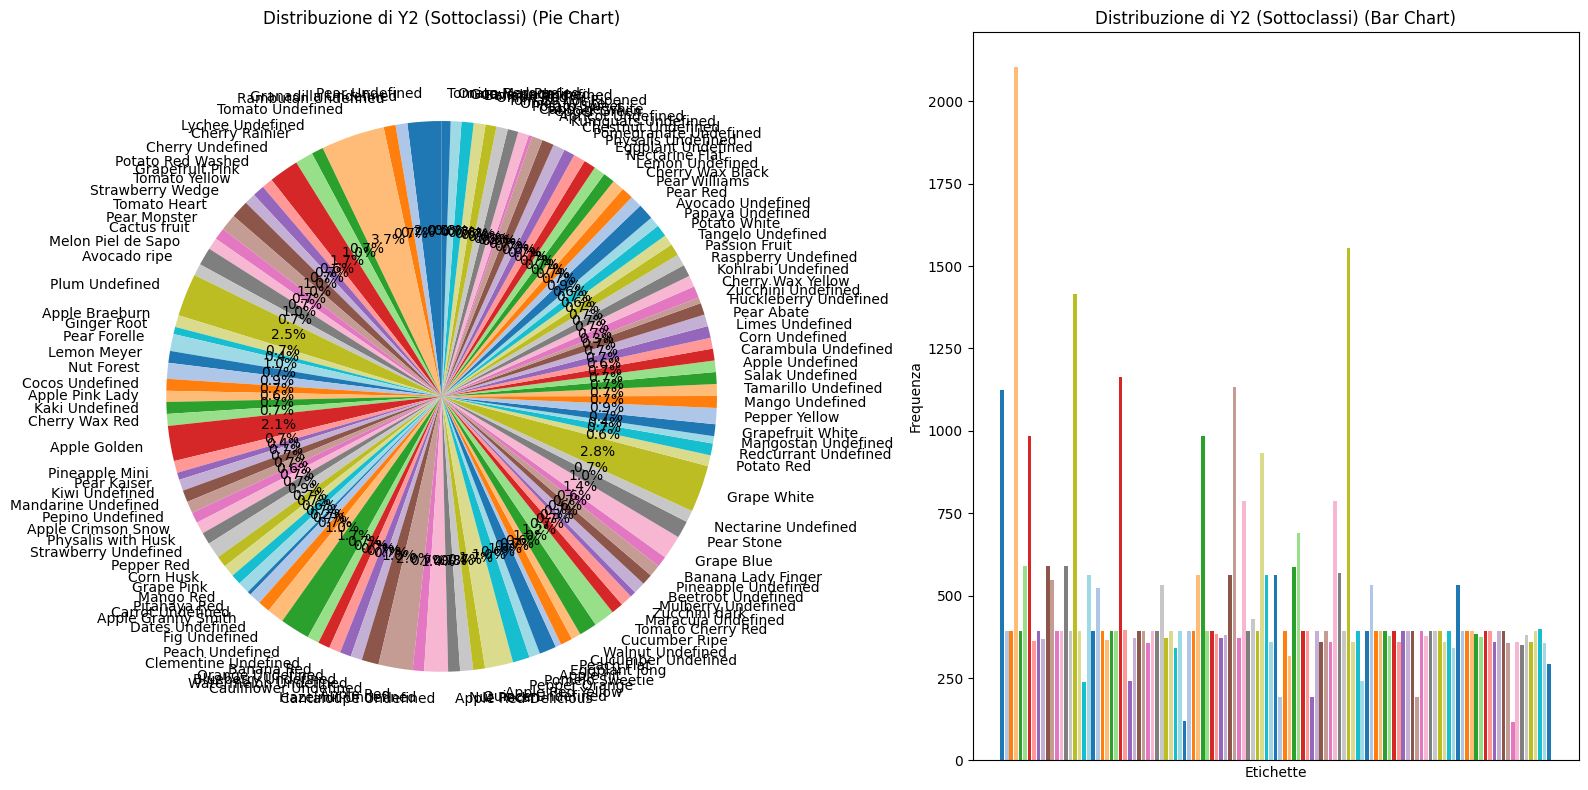

In [31]:
# Plot distribuzione di y2_train
label_names_y2 = list(labels_2_int.keys())  # Nomi per y2
plot_label_distribution(y2_train, label_names_y2, title="Distribuzione di Y2 (Sottoclassi)")

Dai grafici appena mostrati ci possiamo ricredere, risulta infatti eviddente (specialmente dal diagramma a barre) che seppur la maggior parte delle classi abbia un numero vicino alle 300 istanze ci sono comunque molte altre classi che hanno o un numero minore di 250 samples o maggiore di 350. Queste venngono meglio visualizzate nel prossimo plot:

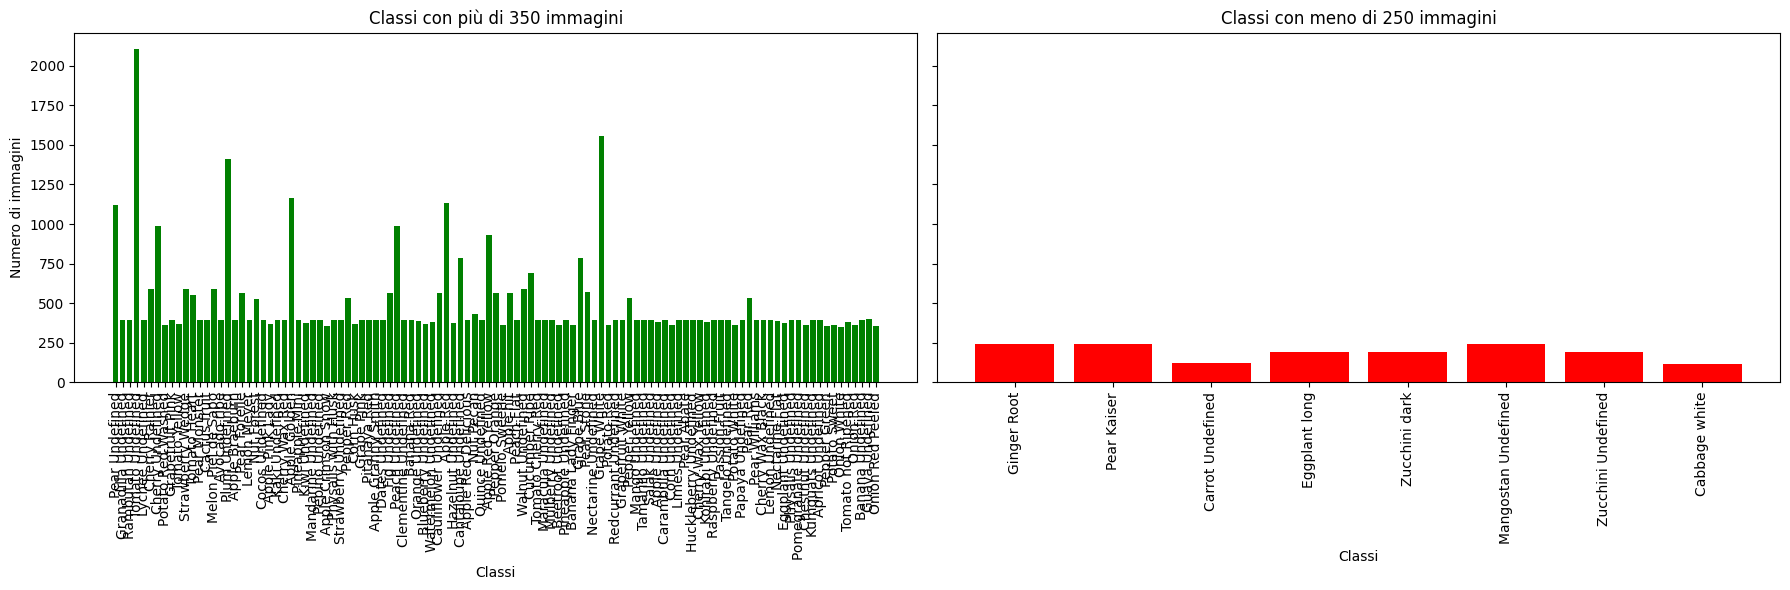

In [32]:
# Converti one-hot encoding in indici delle classi
class_indices = np.argmax(y2_train, axis=1)

# Conta le occorrenze di ogni classe
class_counts = Counter(class_indices)

# Filtra le classi con meno di 250 e più di 350 immagini
class_over_350 = {label_names_y2[idx]: count for idx, count in class_counts.items() if count > 350}
class_under_250 = {label_names_y2[idx]: count for idx, count in class_counts.items() if count < 250}

# Imposta la figura con due subplot affiancati
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Grafico per le classi con più di 350 immagini
axes[0].bar(class_over_350.keys(), class_over_350.values(), color='green')
axes[0].set_xlabel('Classi')
axes[0].set_ylabel('Numero di immagini')
axes[0].set_title('Classi con più di 350 immagini')
axes[0].tick_params(axis='x', rotation=90)

# Grafico per le classi con meno di 250 immagini
axes[1].bar(class_under_250.keys(), class_under_250.values(), color='red')
axes[1].set_xlabel('Classi')
axes[1].set_title('Classi con meno di 250 immagini')
axes[1].tick_params(axis='x', rotation=90)

# Mostra il grafico
plt.tight_layout()
plt.show()

Dal grafico risulta evidente che ci siamo molte sotto-classi che hanno più di 350 sample e potrebbero portare ad una classificazione sbilanciata. Allo stesso modo, seppur in numero minore, la stessa ossrevazione vale anche per le classi undersamplate.

Per questo motivo potrebbe dunque essere sensato nella fase di preparazione dati potremmo pensare di fare il calcolo dei pesi da assegnare a ciascuna classe per evitare di avere una classificazione spilanciata

#### Studio frequenze per label_1 (classe principale)

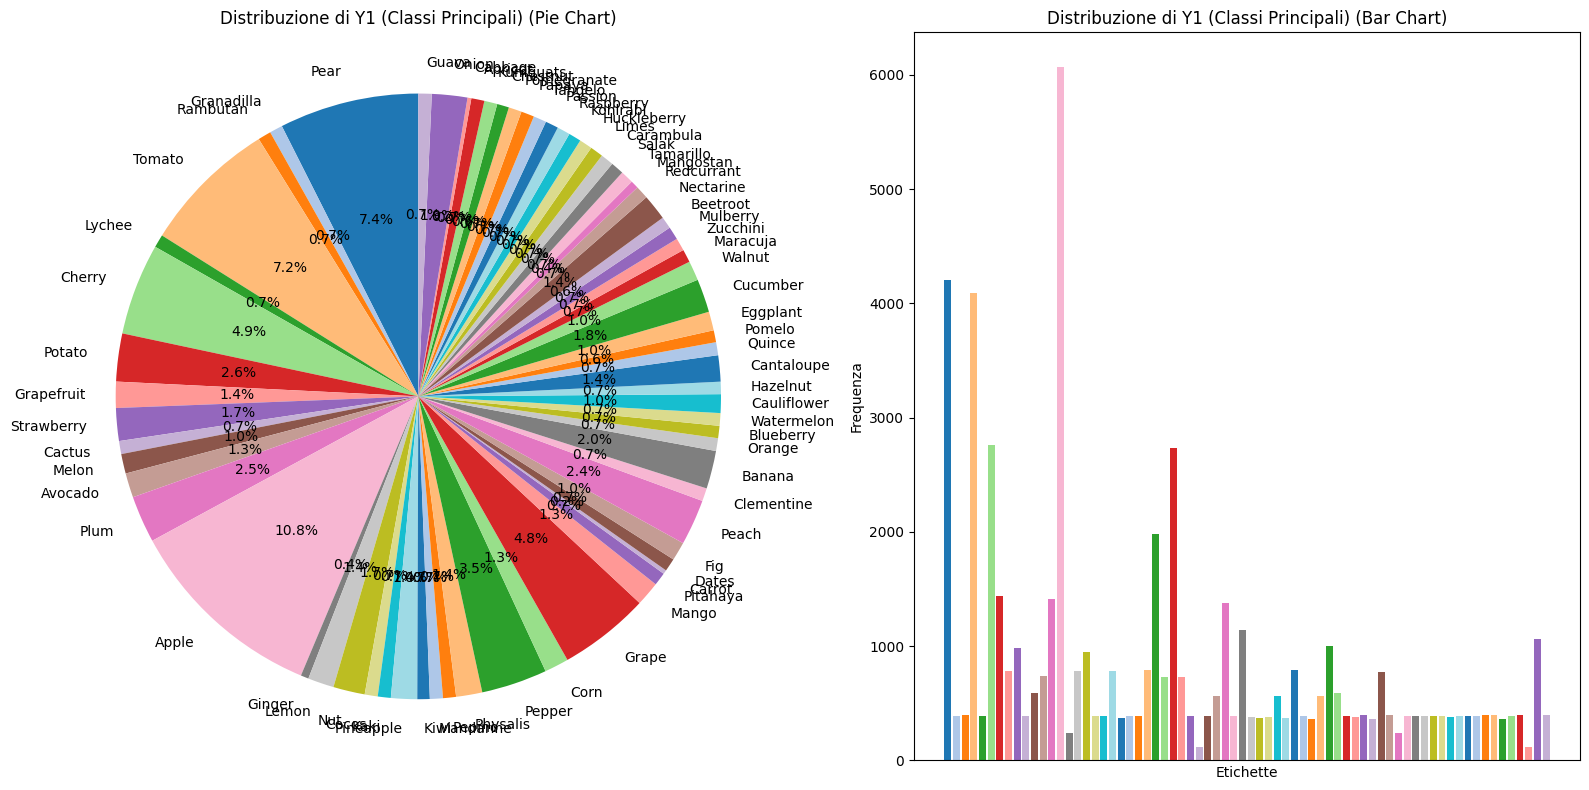

In [33]:
# Plot distribuzione di y1_train
label_names_y1 = list(labels_1_int.keys())  # Nomi per y1
plot_label_distribution(y1_train, label_names_y1, title="Distribuzione di Y1 (Classi Principali)")

In questo caso la differenza di esempi per ogni classe diventa molto più evidente, anche senza bisogno di fare un'analisi più dettagliata come per le label precedenti, per questo motivo si decide di calcolare dei pesi da assegnare a ciascuna classe anche per questa label

Si sceglie di applicare direttamente questo step in fase di lettura dei dati in quanto non comporta alcuna modifica significativa al valore informativo delle informazioni, tutti i dati possono venire comunque letti come se non avesssimo fatto alcuna modifica.

## Preparazione dei dati

Questo step è già stato in gran parte svolto sia nella preparazione manulae del dataset che poi anche nel momento in cui si è definita la funzione che salva i file npz. Abbiamo infatti che in questa funzione ci si assicura anche che tutte le immaigni vengano salvate con la stessa dimensione standard (128,128) e che i valori di tutti e 3 canali di RGB siano sempre compresi tra 0 e 255 per tutte le immagini. Inoltre è anche già stato fatto il one-hot delle labels in fase di pre-processing. Di conseguenza, non ci rimangono

### Calcolo pesi di bilaciamento per ogni classe

Si definisce la seguente funzione per trovare i pesi da assegnare a ciasscuna classe (sia per label 1 che per label 2)

In [34]:
def compute_class_weights(y_train):
    # Converti one-hot encoding in indici delle classi
    class_indices = np.argmax(y_train, axis=1)

    # Conta le occorrenze di ogni classe
    class_counts = Counter(class_indices)

    # Numero totale di sample e di classi
    total_samples = len(class_indices)
    num_classes = len(class_counts)

    # Calcola i pesi: più rara è la classe, più alto è il peso
    class_weights = {cls: total_samples / (num_classes * count) for cls, count in class_counts.items()}

    return class_weights

#### Calcolo pesi bilanciamento sotto-classi (label-2)

In [35]:
# Calcola i pesi per y2
class_weights_y2 = compute_class_weights(y2_train)

# Mostra i pesi calcolati
print("Pesi per y2_train:", class_weights_y2)

Pesi per y2_train: {np.int64(77): 0.4153573294672623, np.int64(41): 1.1899139821217743, np.int64(103): 1.1838738096236943, np.int64(111): 0.2216950004713572, np.int64(57): 1.1899139821217743, np.int64(25): 0.7892492064157962, np.int64(24): 0.4735495238494777, np.int64(99): 1.2849759806934864, np.int64(45): 1.1899139821217743, np.int64(116): 1.2675170679123249, np.int64(108): 0.7892492064157962, np.int64(113): 0.8511793448754298, np.int64(81): 1.1899139821217743, np.int64(19): 1.1899139821217743, np.int64(63): 0.7892492064157962, np.int64(12): 1.1868862111748997, np.int64(95): 0.3298771435585117, np.int64(1): 1.1838738096236943, np.int64(40): 1.9598583234946871, np.int64(79): 0.8299755889532661, np.int64(55): 1.1899139821217743, np.int64(67): 0.8901646583811746, np.int64(31): 1.1899139821217743, np.int64(6): 1.2779350164157137, np.int64(50): 1.1899139821217743, np.int64(27): 1.1838738096236943, np.int64(3): 0.40107160876331516, np.int64(93): 1.180876660738571, np.int64(80): 1.9435261707

#### Calcolo pesi bilanciamento classi principali (label-1)

In [36]:
# Calcola i pesi per y1
class_weights_y1 = compute_class_weights(y1_train)

# Mostra i pesi calcolati
print("Pesi per y1_train:", class_weights_y1)

Pesi per y1_train: {np.int64(48): 0.19183576357023893, np.int64(22): 2.056851311953353, np.int64(59): 2.046410442349529, np.int64(66): 0.19723231758456808, np.int64(34): 2.056851311953353, np.int64(12): 0.2923443489070755, np.int64(57): 0.5587565587565587, np.int64(24): 1.025808796801163, np.int64(63): 0.8185641769398114, np.int64(7): 2.056851311953353, np.int64(39): 1.364273628233019, np.int64(2): 1.0969873663751215, np.int64(54): 0.5702162052939987, np.int64(0): 0.1328531412565026, np.int64(21): 3.3877551020408165, np.int64(32): 1.025808796801163, np.int64(42): 0.8469387755102041, np.int64(15): 2.056851311953353, np.int64(28): 2.056851311953353, np.int64(52): 1.0245053548738428, np.int64(29): 2.1616238988893146, np.int64(35): 2.056851311953353, np.int64(49): 2.056851311953353, np.int64(51): 1.0232052211747644, np.int64(50): 0.40639400921658986, np.int64(16): 1.1045009784735813, np.int64(23): 0.29458740017746227, np.int64(36): 1.099980510621711, np.int64(53): 2.056851311953353, np.int

### Calcolo pesi di bilanciamento per samples

Keras sfortunatamente non supporta direttamente class_weight per modelli con più output. (Che è esattamente il tipo di modello che vogliamo sviluppare in questo progetto). Possiamo però raggirare il problema usando i pesi manuali per ciascun output, sfruttando sample_weight invece di class_weight. Di seguito si calcolano quindi i pesi manuali da aasegnare ai sample:

In [37]:
def compute_sample_weights(y_train, class_weights):
    # Converti da one-hot a indici delle classi
    class_indices = np.argmax(y_train, axis=1)

    # Assegna il peso corrispondente a ciascun sample
    sample_weights = np.array([class_weights[idx] for idx in class_indices])

    return sample_weights

#### Calcolo pesi bilanciamento sotto-classi (label-2)

In [38]:
# Genera i pesi per ogni sample
sample_weights_y2 =  np.array(compute_sample_weights(y2_train, class_weights_y2))

#### Calcolo pesi bilanciamento classi principali (label-1)

In [39]:
# Genera i pesi per ogni sample
sample_weights_y1 = np.array( compute_sample_weights(y1_train, class_weights_y1) )

#### Calcolo pesi condivisi

Siccome abbiamo che nella rete i layer che identificano le labe_1 e label_2 sono condivise possiamo mergiare questi pesi nel seguente modo:

In [40]:
# Combine sample weights for y1 and y2
combined_sample_weights = (sample_weights_y1 + sample_weights_y2) / 2

### Controllo conformità dati

In [41]:
def check_data_conformity(x, y1, y2, sample_weights_y1=None, sample_weights_y2=None, dataset_name="train"):
    errors = []

    # 1 Controllo dimensione dataset
    num_samples = x.shape[0]

    if y1.shape[0] != num_samples:
        errors.append(f"❌ {dataset_name}: y1 ha {y1.shape[0]} campioni, ma x ne ha {num_samples}")

    if y2.shape[0] != num_samples:
        errors.append(f"❌ {dataset_name}: y2 ha {y2.shape[0]} campioni, ma x ne ha {num_samples}")

    # 2️ Controllo se le etichette sono one-hot encoded
    if len(y1.shape) != 2:
        errors.append(f"❌ {dataset_name}: y1 dovrebbe essere one-hot encoded (shape 2D), ma ha shape {y1.shape}")

    if len(y2.shape) != 2:
        errors.append(f"❌ {dataset_name}: y2 dovrebbe essere one-hot encoded (shape 2D), ma ha shape {y2.shape}")

    # 3️ Controllo sample_weights per y1
    if sample_weights_y1 is not None:
        if sample_weights_y1.shape[0] != num_samples:
            errors.append(f"❌ {dataset_name}: sample_weights_y1 ha {sample_weights_y1.shape[0]} campioni, ma x ne ha {num_samples}")

    # 4️ Controllo sample_weights per y2
    if sample_weights_y2 is not None:
        if sample_weights_y2.shape[0] != num_samples:
            errors.append(f"❌ {dataset_name}: sample_weights_y2 ha {sample_weights_y2.shape[0]} campioni, ma x ne ha {num_samples}")

    # Se non ci sono errori, tutto è conforme
    if not errors:
        print(f"✅ {dataset_name}: Tutti i dati sono conformi!")
    else:
        for error in errors:
            print(error)

In [42]:
check_data_conformity(x_train, y1_train, y2_train, sample_weights_y1, sample_weights_y2, dataset_name="Train")
check_data_conformity(x_val, y1_val, y2_val, dataset_name="Validation")
check_data_conformity(x_test, y1_test, y2_test, dataset_name="Test")

✅ Train: Tutti i dati sono conformi!
✅ Validation: Tutti i dati sono conformi!
✅ Test: Tutti i dati sono conformi!


## Costruzione dei modelli

### Function graph

In [43]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Visualizza i grafici di loss e accuracy per un modello con due output, includendo l'accuracy totale.
    
    Args:
        history: Storia dell'addestramento del modello (output di model.fit())
    """
    epochs = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize=(12, 18))  # Aumento l'altezza per adattare più subplot

    # 🔴 Grafico della Loss totale
    plt.subplot(3, 2, 1)
    plt.plot(epochs, history.history['loss'], 'r-', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'r--', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Total Loss')

    # 🔵 Grafico della Loss Y1 (Fruit)
    plt.subplot(3, 2, 2)
    plt.plot(epochs, history.history['y1_loss'], 'b-', label='Y1 (Fruit) Loss')
    plt.plot(epochs, history.history['val_y1_loss'], 'b--', label='Val Y1 Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Y1 (Fruit) Loss')

    # 🟢 Grafico della Loss Y2 (Quality)
    plt.subplot(3, 2, 3)
    plt.plot(epochs, history.history['y2_loss'], 'g-', label='Y2 (Quality) Loss')
    plt.plot(epochs, history.history['val_y2_loss'], 'g--', label='Val Y2 Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Y2 (Quality) Loss')

    # 🔵 Grafico della Accuracy Y1 (Fruit)
    plt.subplot(3, 2, 4)
    plt.plot(epochs, history.history['y1_accuracy'], 'b-', label='Y1 (Fruit) Accuracy')
    plt.plot(epochs, history.history['val_y1_accuracy'], 'b--', label='Val Y1 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Y1 (Fruit) Accuracy')

    # 🟢 Grafico della Accuracy Y2 (Quality)
    plt.subplot(3, 2, 5)
    plt.plot(epochs, history.history['y2_accuracy'], 'g-', label='Y2 (Quality) Accuracy')
    plt.plot(epochs, history.history['val_y2_accuracy'], 'g--', label='Val Y2 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Y2 (Quality) Accuracy')

    # 🟣 Grafico della Accuracy Totale
    total_accuracy = (np.array(history.history['y1_accuracy']) + np.array(history.history['y2_accuracy'])) / 2
    val_total_accuracy = (np.array(history.history['val_y1_accuracy']) + np.array(history.history['val_y2_accuracy'])) / 2

    plt.subplot(3, 2, 6)
    plt.plot(epochs, total_accuracy, 'm-', label='Total Accuracy')
    plt.plot(epochs, val_total_accuracy, 'm--', label='Val Total Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Total Accuracy')

    plt.tight_layout()  # Migliora la disposizione dei grafici
    plt.show()


### VGG19 - Model 1

In [44]:
input_shape = x_train.shape[1:]
num_classes_1 = len(y1_train[0])
num_classes_2 = len(y2_train[0])

In [45]:
dataset_size = len(x_train)  # Numero totale di campioni
epochs_number = 20
batch_size = 32

steps_per_epoch = int(1 * dataset_size / batch_size / epochs_number)
steps_per_val = int(len(x_val) / batch_size / epochs_number)

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Steps per val: {steps_per_val}")

Steps per epoch: 88
Steps per val: 36


In [46]:
# Carica il modello VGG19 pre-addestrato
VGG_model = VGG19(
                weights='imagenet', 
                include_top=False, 
                input_shape=(100, 100, 3),
                input_tensor=None,
                pooling=None,
                classifier_activation="softmax"
            )

In [47]:
VGG_model.trainable = False  # Blocca i pesi del modello pre-addestrato

In [48]:
# Aggiungi strati personalizzati
x = layers.GlobalAveragePooling2D()(VGG_model.output)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.2)(x)

# 🔴 Ramo 1 - Predizione del Frutto
fruit_output = layers.Dense(num_classes_1, activation="softmax", name="y1")(x)

# 🔵 Ramo 2 - Predizione della Qualità
quality_output = layers.Dense(num_classes_2, activation="softmax", name="y2")(x)

In [49]:
# Crea il modello con doppia uscita
model = Model(inputs=VGG_model.input, outputs=[fruit_output, quality_output])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 100, 100,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 100, 100,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 50, 50,    │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 50, 50,    │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 50, 50,    │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 25, 25,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 25, 25,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 25, 25,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 25, 25,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv4        │ (None, 25, 25,    │    590,080 │ block3_conv3[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 12, 12,    │          0 │ block3_conv4[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 12, 12,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 12, 12,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 12, 12,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv4        │ (None, 12, 12,    │  2,359,808 │ block4_conv3[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 6, 6, 512) │          0 │ block4_conv4[0][

 Total params: 20,204,799 (77.08 MB)

 Trainable params: 180,415 (704.75 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [50]:
import tensorflow as tf

def custom_loss(alpha=1.5):
    def loss_fn(y_true, y_pred):
        """
        Loss function that penalizes inconsistent predictions between label1 and label2.

        Args:
            y_true: Concatenated true labels (one-hot encoded) for main and subcategory
            y_pred: Concatenated predicted logits for main and subcategory
        Returns:
            Computed loss value
        """
        # Numero di classi per y1 (principale)
        y1_classes = y_true.shape[1] // 2  # Supponiamo che y_true abbia tutte le classi concatenate

        # Separiamo le etichette principali (y1) e secondarie (y2)
        y1_true, y2_true = y_true[:, :y1_classes], y_true[:, y1_classes:]
        y1_pred, y2_pred = y_pred[:, :y1_classes], y_pred[:, y1_classes:]

        # Standard categorical cross-entropy loss per entrambe le etichette
        loss1 = tf.keras.losses.CategoricalCrossentropy()(y1_true, y1_pred)
        loss2 = tf.keras.losses.CategoricalCrossentropy()(y2_true, y2_pred)

        # Predizioni (argmax)
        y1_pred_label = tf.argmax(y1_pred, axis=-1)
        y2_pred_label = tf.argmax(y2_pred, axis=-1)

        # Etichette vere (argmax)
        y1_true_label = tf.argmax(y1_true, axis=-1)
        y2_true_label = tf.argmax(y2_true, axis=-1)

        # Penalità per inconsistenza tra y1 e y2
        y1_y2_mismatch = tf.cast(tf.not_equal(y1_pred_label, y2_pred_label), tf.float32)
        inconsistency_penalty = alpha * tf.reduce_mean(y1_y2_mismatch)

        # Loss finale
        return loss1 + loss2 + inconsistency_penalty

    return loss_fn  # Restituisci la funzione da usare in Keras

In [51]:
# Definisci il numero di classi
num_classes_1 = len(y1_train[0])  # Classi dei frutti
num_classes_2 = len(y2_train[0])  # Classi della qualità

# Compila il modello
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),

    loss=custom_loss(),

    metrics={
        'y1': 'accuracy', 
        'y2': 'accuracy'
        }
)

In [52]:
early_stopping = EarlyStopping(
    monitor="val_loss",  # Controlla la perdita sulla validation set
    patience=2,          # Numero di epoche senza miglioramento prima di fermarsi
    min_delta=0.001,     # Soglia per considerare un miglioramento
)

history = model.fit(
    x_train,
    {'y1': y1_train, 
     'y2': y2_train},
    validation_data=(
        x_val, {
            'y1': y1_val, 
            'y2': y2_val}),
    epochs=epochs_number,
    batch_size=batch_size,
    steps_per_epoch=steps_per_epoch,
    validation_steps=steps_per_val
)

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - loss: 24.9670 - y1_accuracy: 0.1405 - y1_loss: 11.2624 - y2_accuracy: 0.0595 - y2_loss: 13.7046 - val_loss: 7.7075 - val_y1_accuracy: 0.7526 - val_y1_loss: 1.7041 - val_y2_accuracy: 0.0477 - val_y2_loss: 6.0034
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - loss: 12.0874 - y1_accuracy: 0.3872 - y1_loss: 5.3439 - y2_accuracy: 0.2466 - y2_loss: 6.7435 - val_loss: 5.0741 - val_y1_accuracy: 0.7639 - val_y1_loss: 1.9084 - val_y2_accuracy: 0.5538 - val_y2_loss: 3.1657
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - loss: 6.3916 - y1_accuracy: 0.5432 - y1_loss: 2.7179 - y2_accuracy: 0.4475 - y2_loss: 3.6737 - val_loss: 4.1705 - val_y1_accuracy: 0.8984 - val_y1_loss: 1.5869 - val_y2_accuracy: 0.5582 - val_y2_loss: 2.5836
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - loss: 4.7368 - y1_accuracy: 0.6579 - y1_loss: 2.0775 - y2_accuracy: 0.6041 - y2_loss: 2.6593 - val_loss: 3.9524 - val_y1_accuracy: 0.8932 - val_y1_loss: 1.5781 

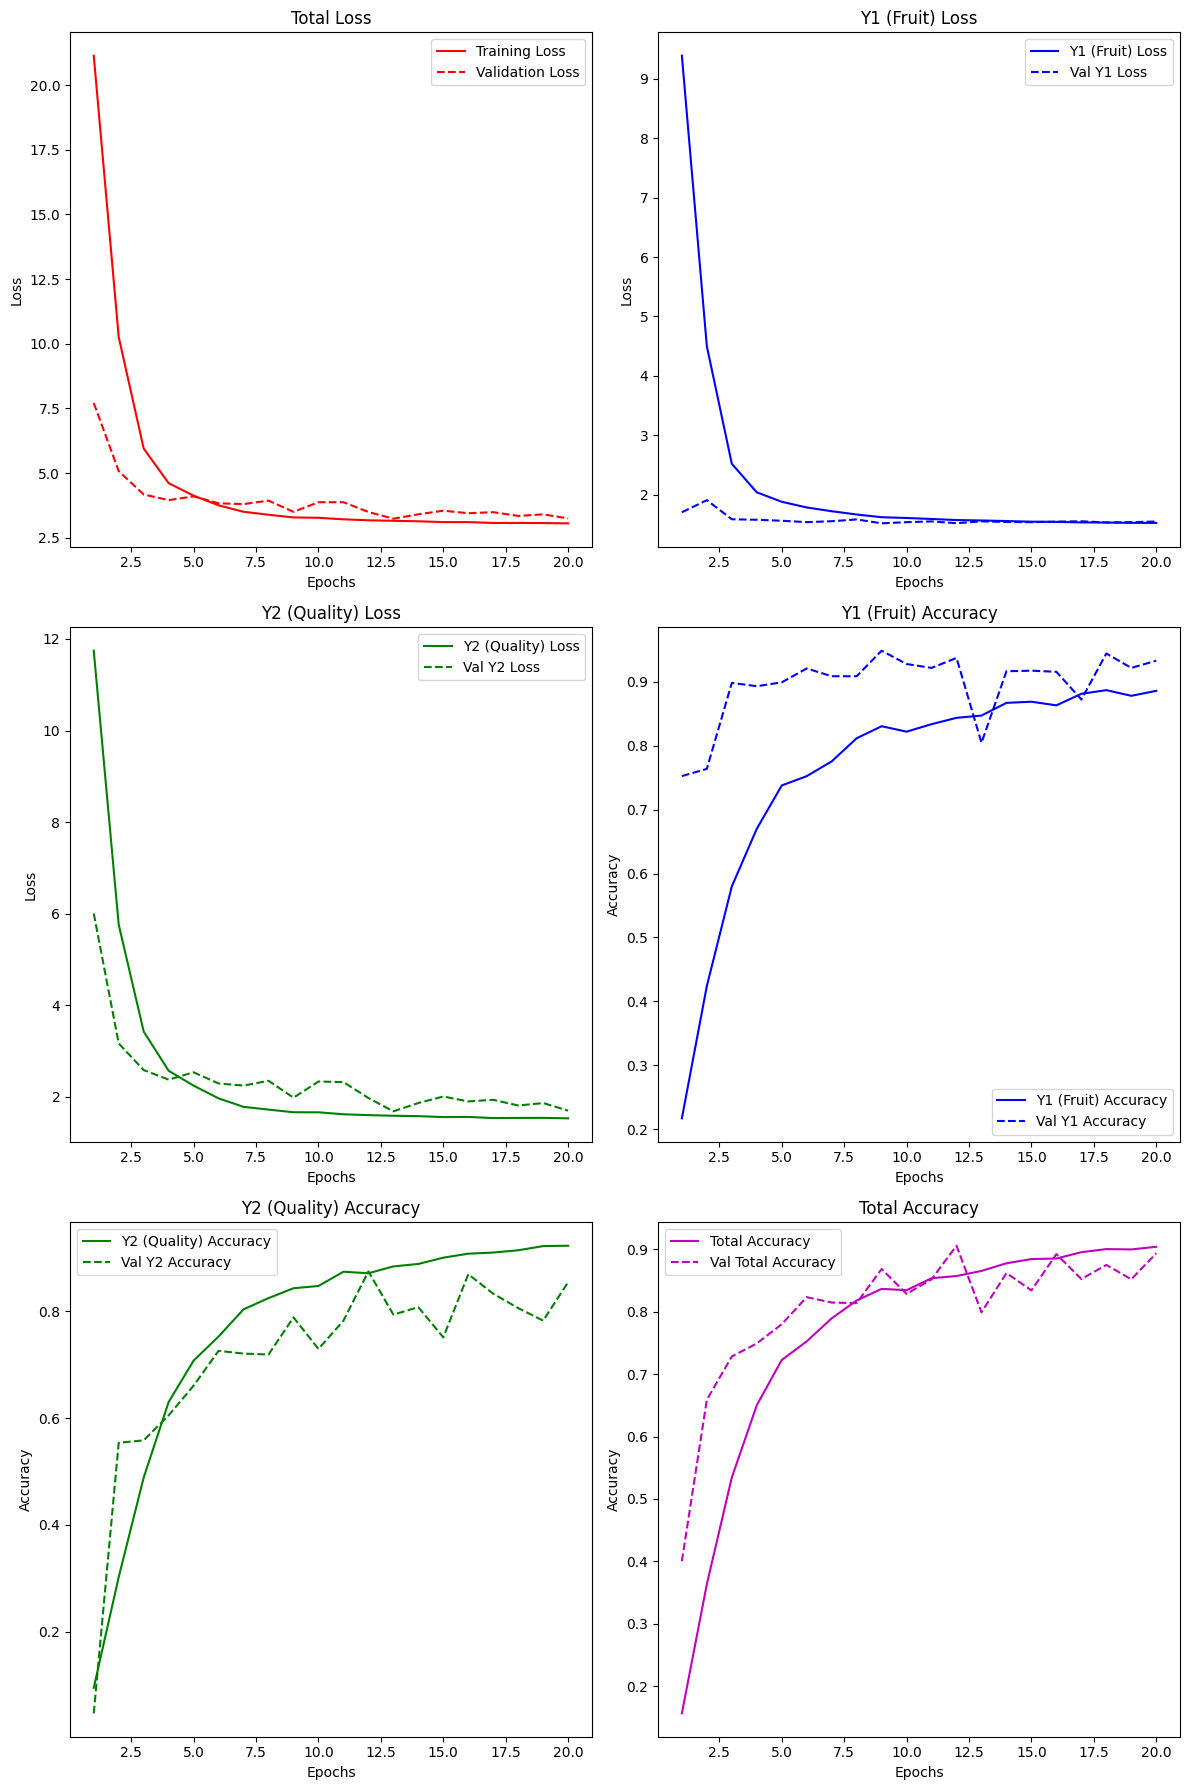

In [53]:
# Dopo l'addestramento del modello
plot_training_history(history)

In [55]:
model.save("keras/model-V0.keras")

In [57]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# 📂 Cartella con le immagini di test
test_folder = "Ext_Test"  # Cambia con il percorso esatto

# 📏 Dimensione delle immagini come usata nel training
img_size = (100, 100)

# 🔄 Carica e preprocessa le immagini
def load_and_preprocess_image(img_path):
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0  # Normalizza i pixel tra 0 e 1
    return img_array

# 📂 Lista di immagini di test
test_images = []
image_names = []

for img_name in os.listdir(test_folder):
    img_path = os.path.join(test_folder, img_name)
    test_images.append(load_and_preprocess_image(img_path))
    image_names.append(img_name)

# 📊 Converti in numpy array
x_test = np.array(test_images)

# 🔮 Effettua le predizioni
predictions = model.predict(x_test)

# 🎯 Estrai le due predizioni (frutto + qualità)
y1_preds = np.argmax(predictions[0], axis=1)  # Predizioni per Y1 (Frutto)
y2_preds = np.argmax(predictions[1], axis=1)  # Predizioni per Y2 (Qualità)

# 🏷️ Mappatura delle classi
y1_labels = labels_1_array # Cambia con le tue classi
y2_labels = labels_2_array

# 📊 Converte gli indici in etichette
y1_predictions = [y1_labels[idx] for idx in y1_preds]
y2_predictions = [y2_labels[idx] for idx in y2_preds]

# 📋 Stampa i risultati nel formato desiderato
for i, img_name in enumerate(image_names):
    print("-" * 50)
    print(f"1/1 ------------------- ⏳ {np.random.randint(50, 800)}ms/step")
    print(f"Image: {img_name}")
    print(f"Predicted Label 1: {y1_predictions[i]}, Predicted Label 2: {y2_predictions[i]}")
    print("-" * 50)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 915ms/step
--------------------------------------------------
1/1 ------------------- ⏳ 767ms/step
Image: Apple Golden 2.jpeg
Predicted Label 1: Pear, Predicted Label 2: Apple Undefined
--------------------------------------------------
--------------------------------------------------
1/1 ------------------- ⏳ 760ms/step
Image: Apple Golden con sfondo.jpeg
Predicted Label 1: Pear, Predicted Label 2: Apple Undefined
--------------------------------------------------
--------------------------------------------------
1/1 ------------------- ⏳ 175ms/step
Image: Apple Golden.jpg
Predicted Label 1: Pear, Predicted Label 2: Apple Undefined
--------------------------------------------------
--------------------------------------------------
1/1 ------------------- ⏳ 495ms/step
Image: apple-braeburn.jpg
Predicted Label 1: Pear, Predicted Label 2: Apple Undefined
--------------------------------------------------
--------------------------------------------------
1